<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E4-SpamClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Exercise 3

## Spam Classification

### Context

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5f221a7871caeecd27b77de09b160f8d4d6fec8f0f4b62d75b01795985669f3e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc,
    roc_curve,
)

import gensim
from gensim.models import Word2Vec
import warnings


warnings.filterwarnings("ignore")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2023-09-11 17:47:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [  <=>               ] 198.65K   469KB/s    in 0.4s    

2023-09-11 17:47:48 (469 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
display(df.shape)  # Number of rows (instances) and columns in the dataset
df["target"].value_counts() / df.shape[0]  # Class distribution in the dataset

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [ ]:
X = df["text"]
y = df["target"].map({"ham": 0, "spam": 1})

In [ ]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=df["target"], test_size=0.3, random_state=18
)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [ ]:
stop_words = set(stopwords.words("english"))


def preprocess(text):
    text = text.lower()
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)


X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.


In [ ]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(
    sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4
)

Convert the preprocessed text data to a vector representation using the Word2Vec model.


In [ ]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)


X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
X_train

array([[-0.05393501,  0.20617983, -0.0501092 , ..., -0.29848632,
         0.11499913, -0.03554979],
       [-0.14267683,  0.50889486, -0.13371192, ..., -0.75160468,
         0.2816619 , -0.09235888],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.05059454,  0.19273016, -0.04789185, ..., -0.28034827,
         0.10440069, -0.03411365],
       [-0.14101665,  0.51574892, -0.1354534 , ..., -0.7640326 ,
         0.28614825, -0.09694397],
       [-0.17938885,  0.64317399, -0.16625655, ..., -0.95055997,
         0.35330352, -0.11457501]])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.


In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.


In [ ]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

Removiendo stopwords, puntuación, convirtiendo a minúsculas y stemmatizando


In [ ]:
from nltk.stem.snowball import SnowballStemmer

stop_words = set(stopwords.words("english"))
englishstemmer = SnowballStemmer("english")


def new_preprocess(text):
    text = text.lower()
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stema = [englishstemmer.stem(w) for w in tokens]  # devuelve palabras stemizadas
    return " ".join(stema)

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler


def Random_F(X_train, y_train, X_val, y_val):
    # estandarizar data - entre 0 y 1
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Modelo
    modelo = RandomForestClassifier(n_jobs=-1, random_state=42)
    modelo.fit(X_train, y_train)
    y_pred_rf = modelo.predict(X_val)
    auc_ = roc_auc_score(y_val, y_pred_rf)
    return y_pred_rf, accuracy_score(y_val, y_pred_rf), auc_

In [ ]:
X_new = X.apply(new_preprocess)
X_new.head()

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri 2 wkli comp win fa cup final tkts 2...
3                  u dun say earli hor u c alreadi say
4            nah dont think goe usf live around though
Name: text, dtype: object

Se emplea CountVectorizer


In [ ]:
count_vect = CountVectorizer(stop_words="english")

In [ ]:
CountV = count_vect.fit_transform(X_new).toarray()
CountV.shape

(5572, 7958)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    CountV, y, test_size=0.2, random_state=42
)

In [ ]:
_, accuracy_rf, auc_rf = Random_F(X_train, y_train, X_test, y_test)
print(f"Accuracy: {accuracy_rf}")
print(f"AUC: {auc_rf}")

Accuracy: 0.9748878923766816
AUC: 0.9060402684563759


In [ ]:
_, accuracy_rf, auc_rf = Random_F(X_train, y_train, X_test, y_test)
print(f"Accuracy: {accuracy_rf}")
print(f"AUC: {auc_rf}")

Accuracy: 0.9748878923766816
AUC: 0.9060402684563759


# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier


In [ ]:
td_idf = TfidfVectorizer(stop_words="english")

In [ ]:
td_idf_V = td_idf.fit_transform(X_new).toarray()
td_idf_V.shape

(5572, 7958)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    td_idf_V, y, test_size=0.2, random_state=42
)

In [ ]:
_, accuracy_rf, auc_rf = Random_F(X_train, y_train, X_test, y_test)
print(f"Accuracy TD-IDF: {accuracy_rf}")
print(f"AUC TD-IDF: {auc_rf}")

Accuracy TD-IDF: 0.9748878923766816
AUC TD-IDF: 0.9060402684563759


# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why


Se aplicarán ambos modelos para ver cuál genera mejores resltados


### **Modelo XGBoost**


In [ ]:
from xgboost import XGBClassifier


def XGB_(X_train, y_train, X_val, y_val):
    # estandarizar data - entre 0 y 1
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Modelo
    xgb = XGBClassifier(eval_metric="mlogloss", n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    auc_ = roc_auc_score(y_val, y_pred)
    # fpr, tpr, _ = roc_curve(y_val, y_pred)
    return y_pred, accuracy_score(y_val, y_pred), auc_

### **Count Vectorizer**


In [ ]:
count_vect = CountVectorizer(stop_words="english")

In [ ]:
CountV = count_vect.fit_transform(X_new).toarray()
CountV.shape

(5572, 7958)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    CountV, y, test_size=0.2, random_state=42
)

In [ ]:
_, accuracy_xgb, auc_xgb = XGB_(X_train, y_train, X_test, y_test)
print(f"Accuracy CV XGB: {accuracy_xgb}")
print(f"AUC CV XGB: {auc_xgb}")

Accuracy CV XGB: 0.8672645739910314
AUC CV XGB: 0.5033557046979866


### **IT-IDF**


In [ ]:
td_idf = TfidfVectorizer(stop_words="english")

In [ ]:
td_idf_V = td_idf.fit_transform(X_new).toarray()
td_idf_V.shape

(5572, 7958)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    td_idf_V, y, test_size=0.2, random_state=42
)

In [ ]:
_, accuracy_xgb, auc_xgb = XGB_(X_train, y_train, X_test, y_test)
print(f"Accuracy IT-IDF XGB: {accuracy_xgb}")
print(f"AUC IT-IDF XGB: {auc_xgb}")

Accuracy IT-IDF XGB: 0.8663677130044843
AUC IT-IDF XGB: 0.5


### **Justificación**

Se empleo el modelo XGBoost debido a que los modelos de ensambles suelen tener bajo sesgo y una varianza más baja que los demás modelos. Adicionalmente, es un modelo de árboles y se quiere observar si es mejor para este problema que un Random Forest.


# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.


### **Funciones que aplican para todas las siguientes respuestas**


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42
)

In [ ]:
def vectorize_new(sentence, model, vs):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(vs)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
def cambio_hiperparametros_vs(
    X_train,
    X_test,
    y_train,
    y_test,
    modelo: str,
    vector_size: list = [
        100,
    ],
    window: list = [
        5,
    ],
    negative: list = [
        20,
    ],
):
    accuracy = []
    auc = []
    for vs in vector_size:
        for w in window:
            for n in negative:
                X_train_new, X_test_new = X_train.copy(), X_test.copy()
                sentences = [sentence.split() for sentence in X_train_new]
                model = Word2Vec(
                    sentences,
                    vector_size=vs,
                    window=w,
                    negative=n,
                    min_count=1,
                    workers=4,
                )

                X_train_new = np.array(
                    [vectorize_new(sentence, model, vs) for sentence in X_train_new]
                )
                X_test_new = np.array(
                    [vectorize_new(sentence, model, vs) for sentence in X_test_new]
                )

                if modelo.lower() == "random forest":
                    _, accuracy_, auc_ = Random_F(
                        X_train_new, y_train, X_test_new, y_test
                    )
                elif modelo.lower() == "xgboost":
                    _, accuracy_, auc_ = XGB_(X_train_new, y_train, X_test_new, y_test)
                accuracy.append(accuracy_)
                auc.append(auc_)

                print(
                    f"Finaliza iteración de vector_size: {vs}, window: {w}, negative: {n}"
                )

    return accuracy, auc, vector_size, window, negative

### **parameter variation: `vector_size`**


**Random Forest**


In [ ]:
accuracy_vs, auc_vs, vs, _, _ = cambio_hiperparametros_vs(
    X_train,
    X_test,
    y_train,
    y_test,
    modelo="Random Forest",
    vector_size=list(range(50, 301, 50)),
)

Finaliza iteración de vector_size: 50, window: 5, negative: 20
Finaliza iteración de vector_size: 100, window: 5, negative: 20
Finaliza iteración de vector_size: 150, window: 5, negative: 20
Finaliza iteración de vector_size: 200, window: 5, negative: 20
Finaliza iteración de vector_size: 250, window: 5, negative: 20
Finaliza iteración de vector_size: 300, window: 5, negative: 20


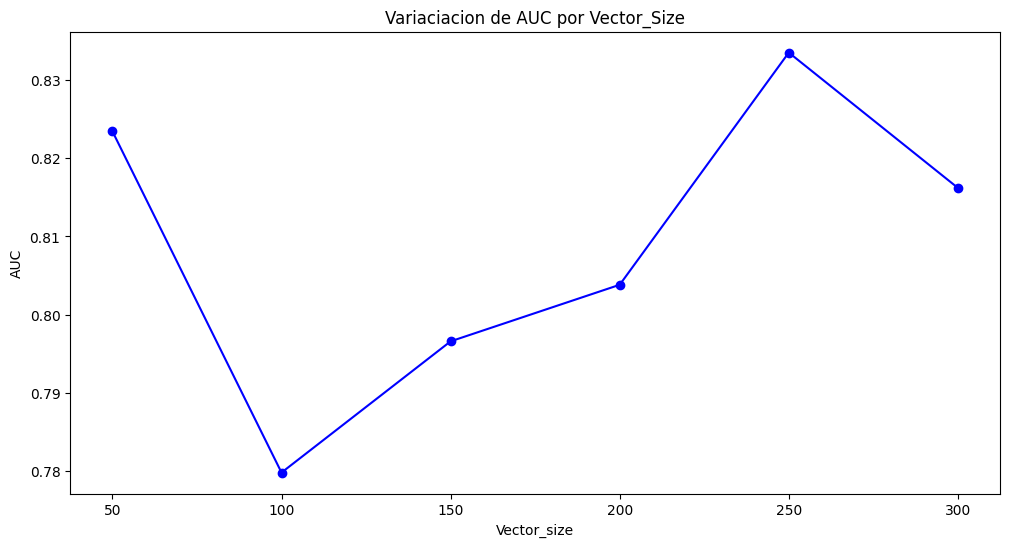

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vs, auc_vs, "o-", color="blue")
plt.xlabel("Vector_size")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Vector_Size")
plt.show()

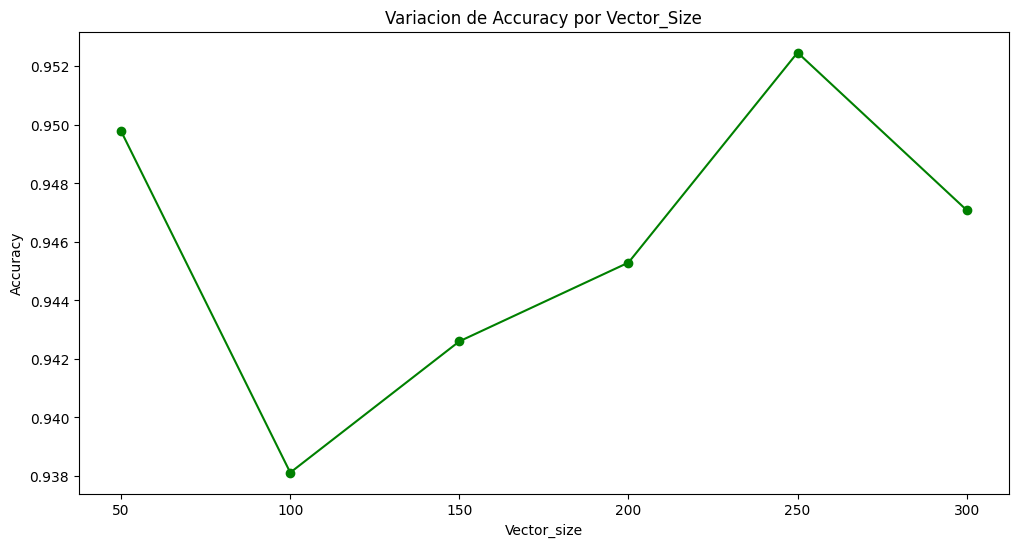

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vs, accuracy_vs, "o-", color="green")
plt.xlabel("Vector_size")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Vector_Size")
plt.show()

**XGBoost**


In [ ]:
accuracy_vs, auc_vs, vs, _, _ = cambio_hiperparametros_vs(
    X_train,
    X_test,
    y_train,
    y_test,
    modelo="XGBoost",
    vector_size=list(range(50, 301, 50)),
)

Finaliza iteración de vector_size: 50, window: 5, negative: 20
Finaliza iteración de vector_size: 100, window: 5, negative: 20
Finaliza iteración de vector_size: 150, window: 5, negative: 20
Finaliza iteración de vector_size: 200, window: 5, negative: 20
Finaliza iteración de vector_size: 250, window: 5, negative: 20
Finaliza iteración de vector_size: 300, window: 5, negative: 20


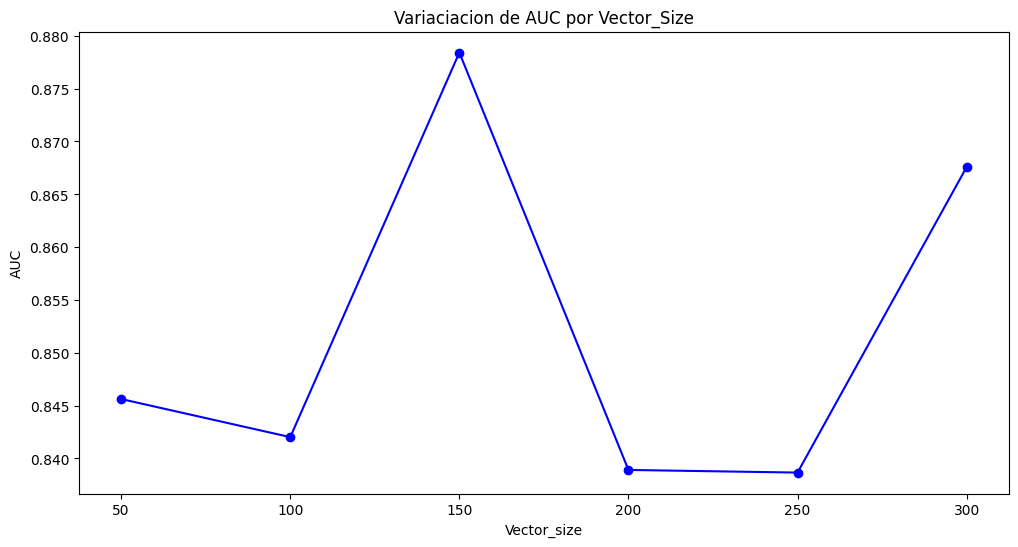

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vs, auc_vs, "o-", color="blue")
plt.xlabel("Vector_size")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Vector_Size")
plt.show()

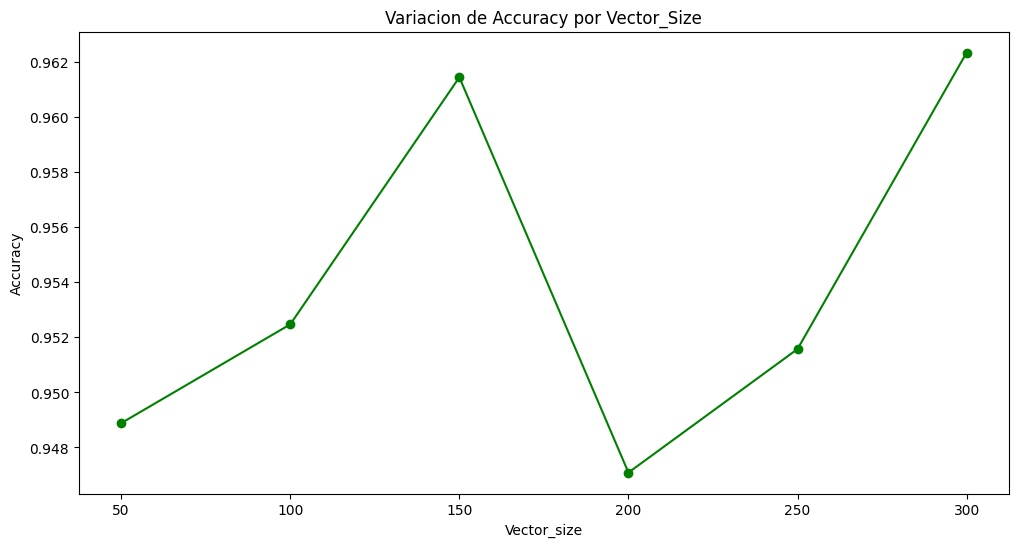

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vs, accuracy_vs, "o-", color="green")
plt.xlabel("Vector_size")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Vector_Size")
plt.show()

### **parameter variation: `window`**


**Random Forest**


In [ ]:
accuracy_w, auc_w, _, w, _ = cambio_hiperparametros_vs(
    X_train, X_test, y_train, y_test, modelo="Random Forest", window=list(range(5, 11))
)

Finaliza iteración de vector_size: 100, window: 5, negative: 20
Finaliza iteración de vector_size: 100, window: 6, negative: 20
Finaliza iteración de vector_size: 100, window: 7, negative: 20
Finaliza iteración de vector_size: 100, window: 8, negative: 20
Finaliza iteración de vector_size: 100, window: 9, negative: 20
Finaliza iteración de vector_size: 100, window: 10, negative: 20


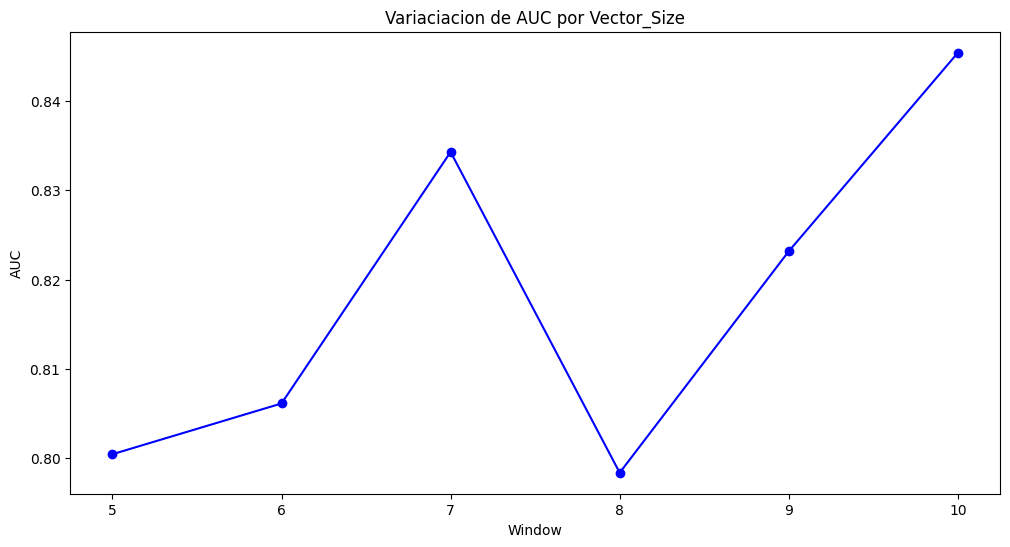

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(w, auc_w, "o-", color="blue")
plt.xlabel("Window")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Vector_Size")
plt.show()

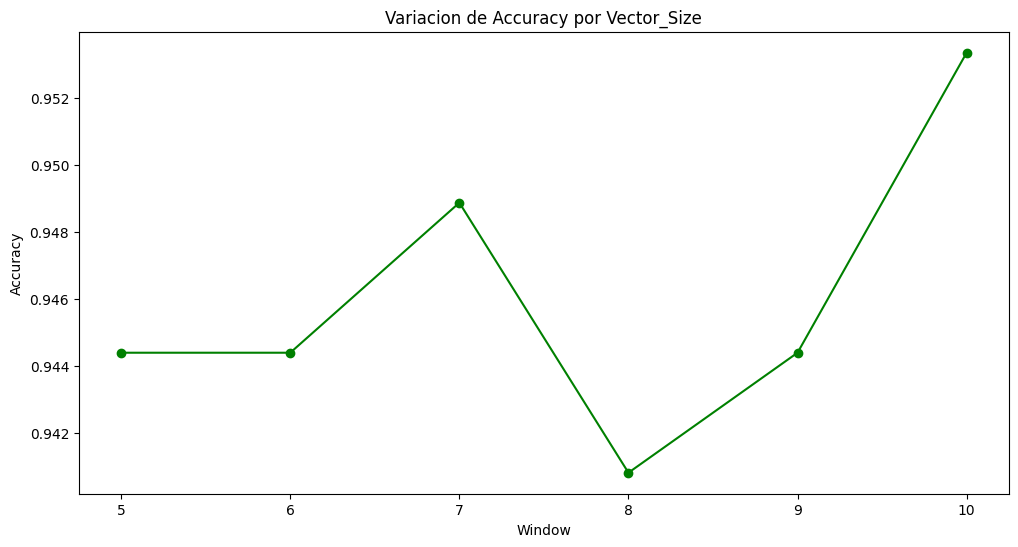

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(w, accuracy_w, "o-", color="green")
plt.xlabel("Window")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Vector_Size")
plt.show()

**XGBoost**


In [ ]:
accuracy_w, auc_w, _, w, _ = cambio_hiperparametros_vs(
    X_train, X_test, y_train, y_test, modelo="XGBoost", window=list(range(5, 11))
)

Finaliza iteración de vector_size: 100, window: 5, negative: 20
Finaliza iteración de vector_size: 100, window: 6, negative: 20
Finaliza iteración de vector_size: 100, window: 7, negative: 20
Finaliza iteración de vector_size: 100, window: 8, negative: 20
Finaliza iteración de vector_size: 100, window: 9, negative: 20
Finaliza iteración de vector_size: 100, window: 10, negative: 20


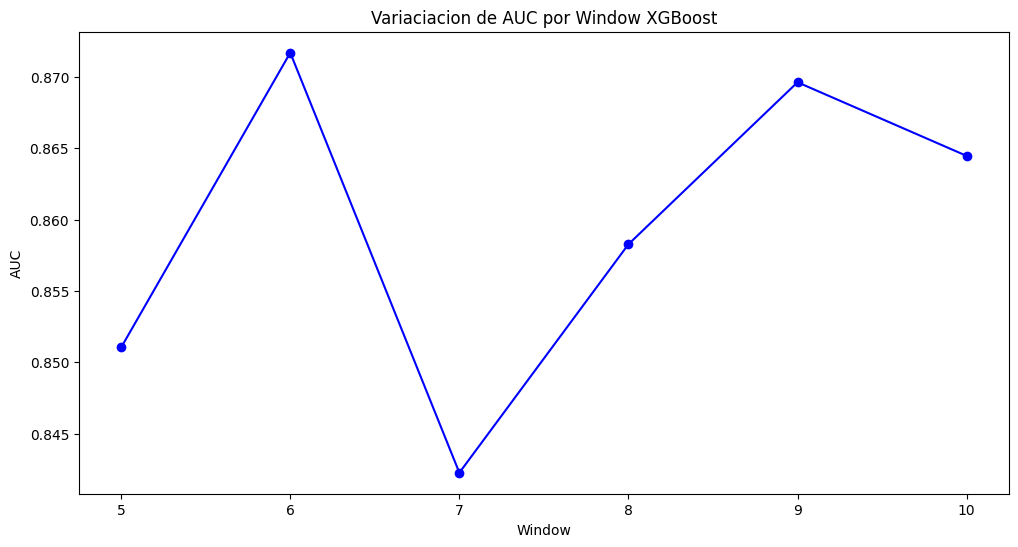

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(w, auc_w, "o-", color="blue")
plt.xlabel("Window")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Window XGBoost")
plt.show()

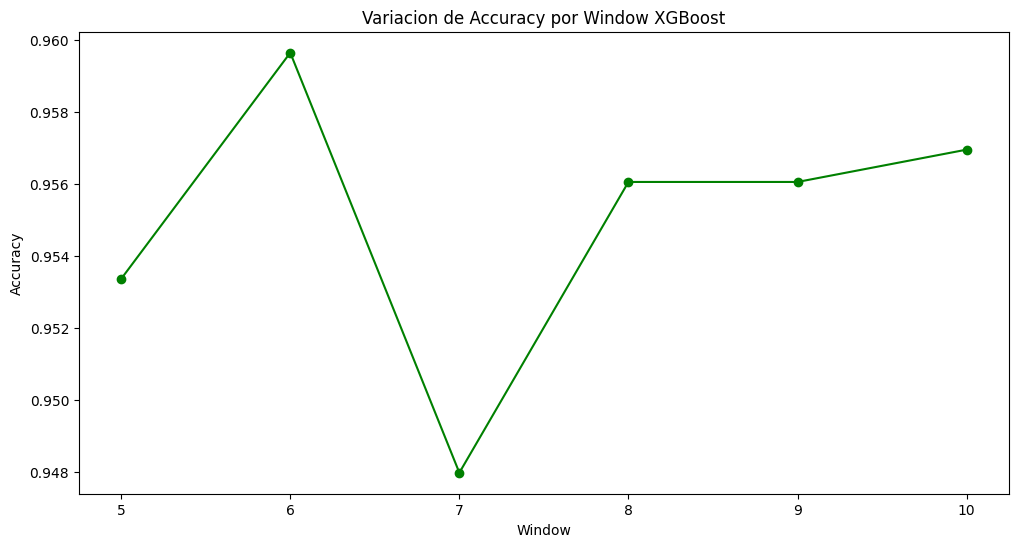

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(w, accuracy_w, "o-", color="green")
plt.xlabel("Window")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Window XGBoost")
plt.show()

### **parameter variation: `negative`**


**Random Forest**


In [ ]:
accuracy_n, auc_n, _, _, n = cambio_hiperparametros_vs(
    X_train,
    X_test,
    y_train,
    y_test,
    modelo="Random Forest",
    negative=list(range(18, 24)),
)

Finaliza iteración de vector_size: 100, window: 5, negative: 18
Finaliza iteración de vector_size: 100, window: 5, negative: 19
Finaliza iteración de vector_size: 100, window: 5, negative: 20
Finaliza iteración de vector_size: 100, window: 5, negative: 21
Finaliza iteración de vector_size: 100, window: 5, negative: 22
Finaliza iteración de vector_size: 100, window: 5, negative: 23


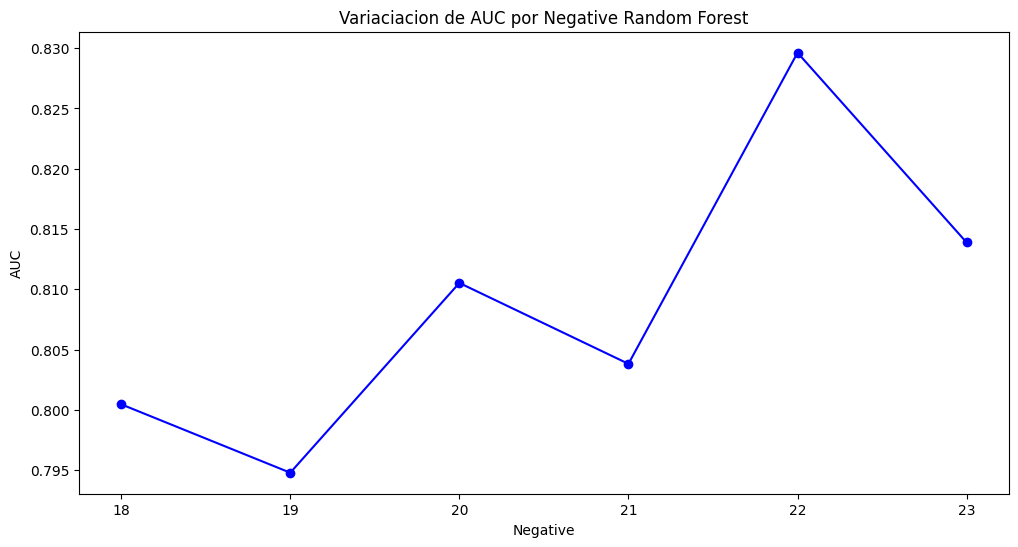

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(n, auc_n, "o-", color="blue")
plt.xlabel("Negative")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Negative Random Forest")
plt.show()

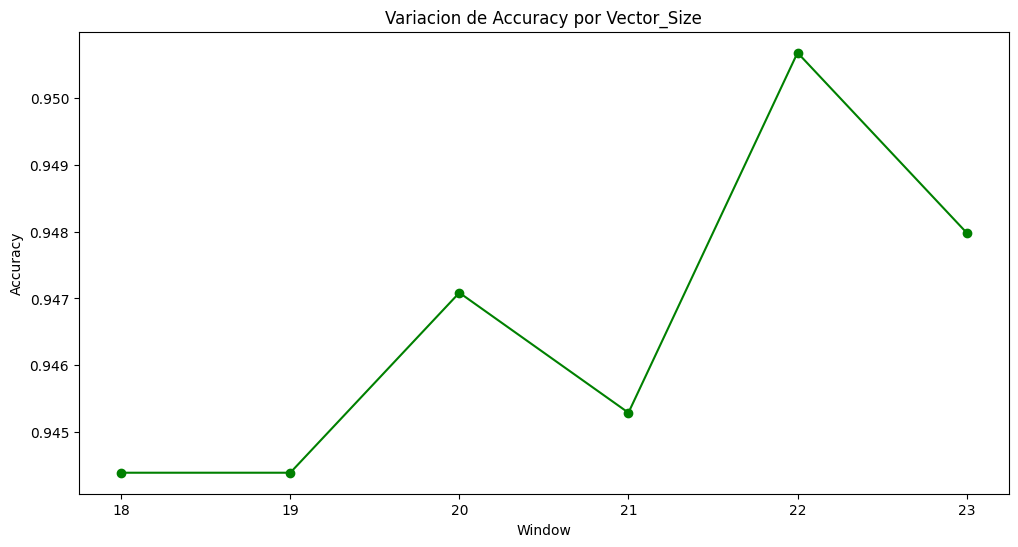

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(n, accuracy_n, "o-", color="green")
plt.xlabel("Window")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Vector_Size")
plt.show()

**XGBoost**


In [ ]:
accuracy_n, auc_n, _, _, n = cambio_hiperparametros_vs(
    X_train, X_test, y_train, y_test, modelo="XGBoost", negative=list(range(18, 24))
)

Finaliza iteración de vector_size: 100, window: 5, negative: 18
Finaliza iteración de vector_size: 100, window: 5, negative: 19
Finaliza iteración de vector_size: 100, window: 5, negative: 20
Finaliza iteración de vector_size: 100, window: 5, negative: 21
Finaliza iteración de vector_size: 100, window: 5, negative: 22
Finaliza iteración de vector_size: 100, window: 5, negative: 23


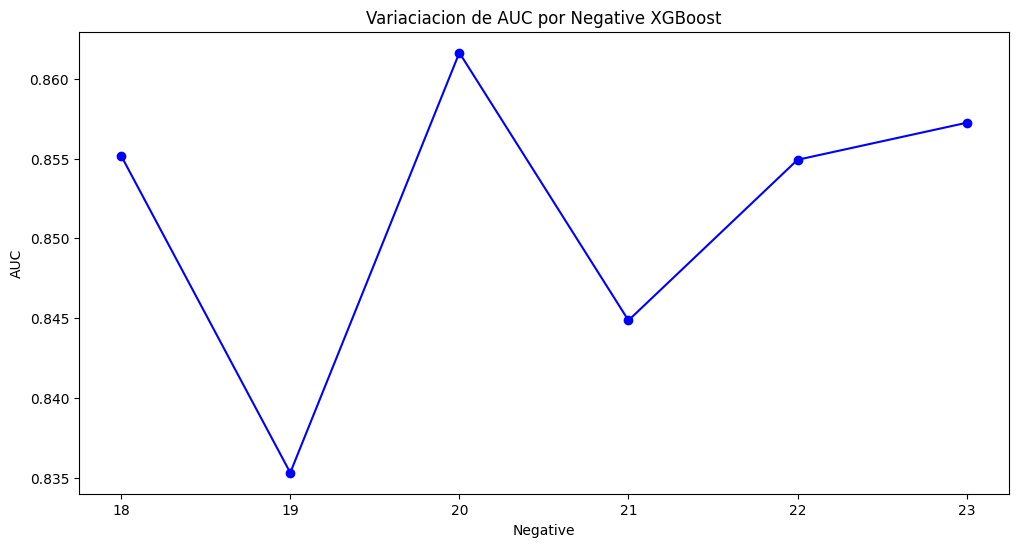

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(n, auc_n, "o-", color="blue")
plt.xlabel("Negative")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Negative XGBoost")
plt.show()

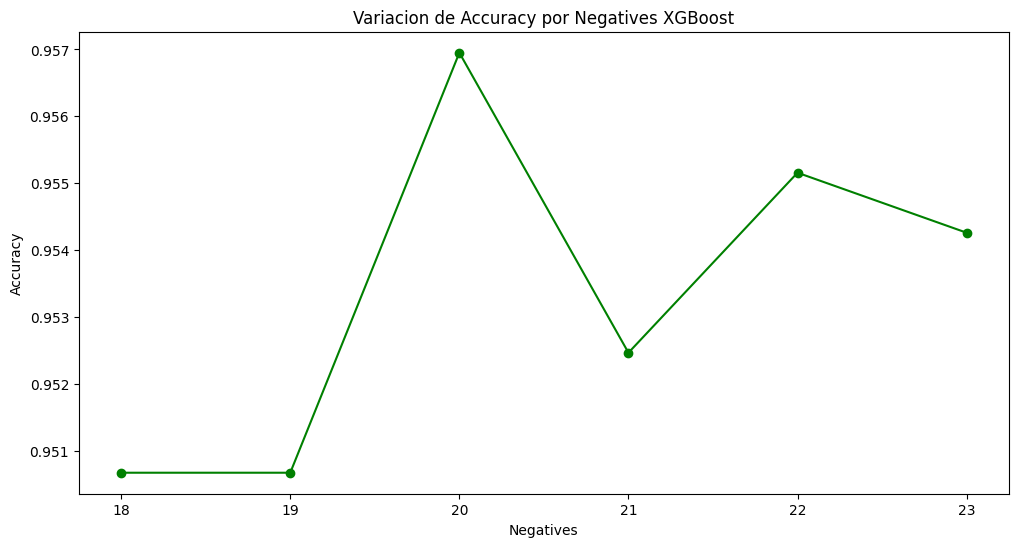

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(n, accuracy_n, "o-", color="green")
plt.xlabel("Negatives")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Negatives XGBoost")
plt.show()

### **Running best parameters `vector_size, window and negative` (All at the same time)**


**Random Forest**


In [ ]:
accuracy_total, auc_total, sv, w, n = cambio_hiperparametros_vs(
    X_train,
    X_test,
    y_train,
    y_test,
    modelo="Random Forest",
    vector_size=list(range(50, 301, 50)),
    window=list(range(5, 11)),
    negative=list(range(18, 24)),
)

Finaliza iteración de vector_size: 50, window: 5, negative: 18
Finaliza iteración de vector_size: 50, window: 5, negative: 19
Finaliza iteración de vector_size: 50, window: 5, negative: 20
Finaliza iteración de vector_size: 50, window: 5, negative: 21
Finaliza iteración de vector_size: 50, window: 5, negative: 22
Finaliza iteración de vector_size: 50, window: 5, negative: 23
Finaliza iteración de vector_size: 50, window: 6, negative: 18
Finaliza iteración de vector_size: 50, window: 6, negative: 19
Finaliza iteración de vector_size: 50, window: 6, negative: 20
Finaliza iteración de vector_size: 50, window: 6, negative: 21
Finaliza iteración de vector_size: 50, window: 6, negative: 22
Finaliza iteración de vector_size: 50, window: 6, negative: 23
Finaliza iteración de vector_size: 50, window: 7, negative: 18
Finaliza iteración de vector_size: 50, window: 7, negative: 19
Finaliza iteración de vector_size: 50, window: 7, negative: 20
Finaliza iteración de vector_size: 50, window: 7, negat

In [ ]:
vector_unido = [
    str(v) + "-" + str(wi) + "-" + str(ne) for v in vs for wi in w for ne in n
]
vector_unido[:5]

['50-5-18', '50-5-19', '50-5-20', '50-5-21', '50-5-22']

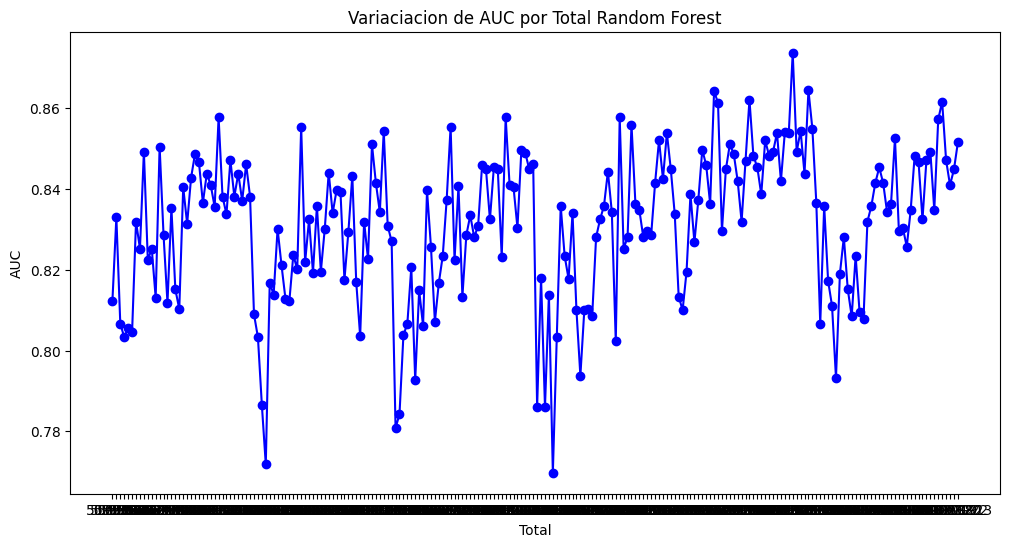

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vector_unido, auc_total, "o-", color="blue")
plt.xlabel("Total")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Total Random Forest")
plt.show()

In [ ]:
index_best = auc_total.index(max(auc_total))
print(
    f"Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: {vector_unido[index_best]}\nQue genero el siguiente resultado {auc_total[index_best]} "
)

Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: 250-9-23
Que genero el siguiente resultado 0.8737685327997554 


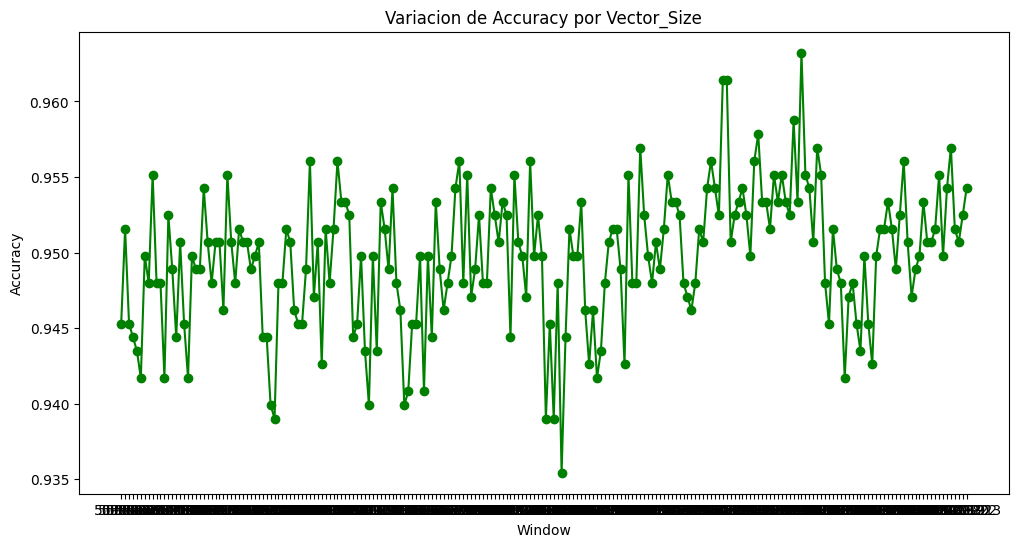

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vector_unido, accuracy_total, "o-", color="green")
plt.xlabel("Window")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Vector_Size")
plt.show()

In [ ]:
index_best = accuracy_total.index(max(accuracy_total))
print(
    f"Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: {vector_unido[index_best]}\nQue genero el siguiente resultado {accuracy_total[index_best]} "
)

Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: 250-9-23
Que genero el siguiente resultado 0.9632286995515695 


**XGBoost**


In [ ]:
accuracy_total, auc_total, sv, w, n = cambio_hiperparametros_vs(
    X_train,
    X_test,
    y_train,
    y_test,
    modelo="XGBoost",
    vector_size=list(range(50, 301, 50)),
    window=list(range(5, 11)),
    negative=list(range(18, 24)),
)

Finaliza iteración de vector_size: 50, window: 5, negative: 18
Finaliza iteración de vector_size: 50, window: 5, negative: 19
Finaliza iteración de vector_size: 50, window: 5, negative: 20
Finaliza iteración de vector_size: 50, window: 5, negative: 21
Finaliza iteración de vector_size: 50, window: 5, negative: 22
Finaliza iteración de vector_size: 50, window: 5, negative: 23
Finaliza iteración de vector_size: 50, window: 6, negative: 18
Finaliza iteración de vector_size: 50, window: 6, negative: 19
Finaliza iteración de vector_size: 50, window: 6, negative: 20
Finaliza iteración de vector_size: 50, window: 6, negative: 21
Finaliza iteración de vector_size: 50, window: 6, negative: 22
Finaliza iteración de vector_size: 50, window: 6, negative: 23
Finaliza iteración de vector_size: 50, window: 7, negative: 18
Finaliza iteración de vector_size: 50, window: 7, negative: 19
Finaliza iteración de vector_size: 50, window: 7, negative: 20
Finaliza iteración de vector_size: 50, window: 7, negat

In [ ]:
vector_unido = [
    str(v) + "-" + str(wi) + "-" + str(ne) for v in vs for wi in w for ne in n
]
vector_unido[:5]

['50-5-18', '50-5-19', '50-5-20', '50-5-21', '50-5-22']

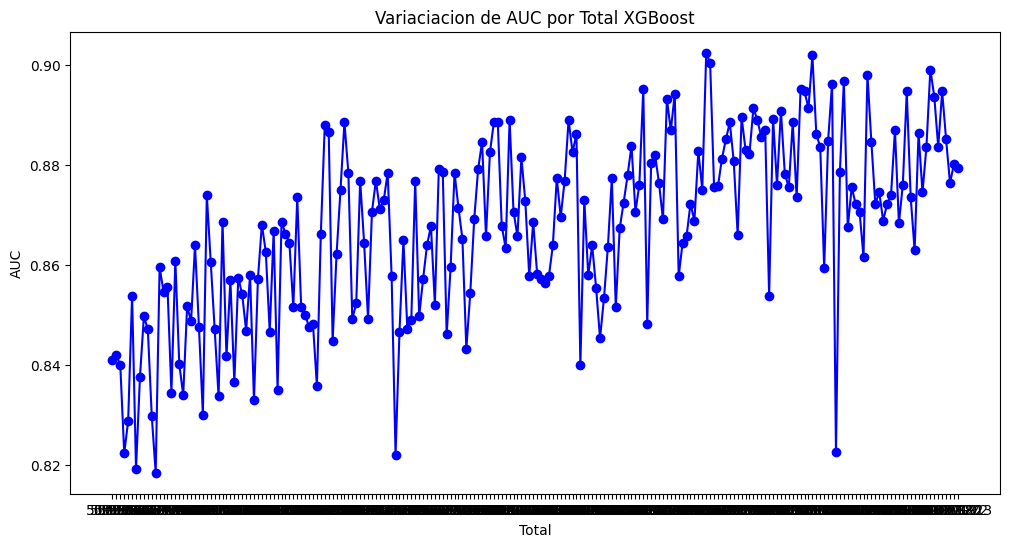

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vector_unido, auc_total, "o-", color="blue")
plt.xlabel("Total")
plt.ylabel("AUC")
plt.title("Variaciacion de AUC por Total XGBoost")
plt.show()

In [ ]:
index_best = auc_total.index(max(auc_total))
print(
    f"Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: {vector_unido[index_best]}\nQue genero el siguiente resultado {auc_total[index_best]} "
)

Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: 250-6-19
Que genero el siguiente resultado 0.9024170800505786 


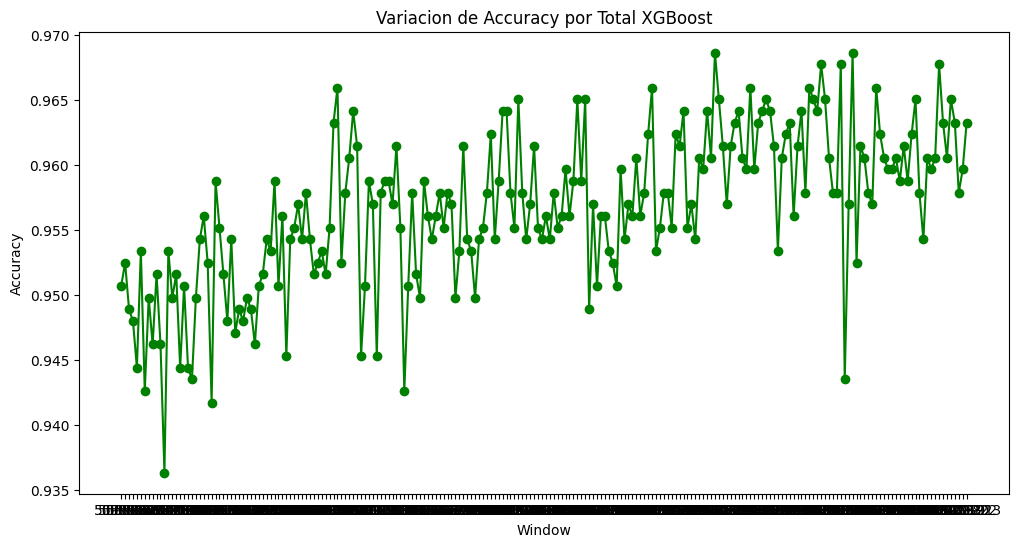

In [ ]:
import matplotlib.pyplot as plt

figure = plt.subplots(figsize=(12, 6))
plt.plot(vector_unido, accuracy_total, "o-", color="green")
plt.xlabel("Window")
plt.ylabel("Accuracy")
plt.title("Variacion de Accuracy por Total XGBoost")
plt.show()

In [ ]:
index_best = accuracy_total.index(max(accuracy_total))
print(
    f"Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: {vector_unido[index_best]}\nQue genero el siguiente resultado {accuracy_total[index_best]} "
)

Se tuvo la mejor mezcla de vector size, window y negative con los siguientes hiperparametros: 250-6-19
Que genero el siguiente resultado 0.968609865470852 


# Conclusiones 

Se muestra que los dos modelos fueron buenos en poder realizar la tarea solicitada. Se aclara que para los embeddings generados por Word2Vec el manejo de los hiper parametros es esencial para poder generar una solución óptima.

Adicional se menciona que la mejor solución se encontró con Word2Vec en el algoritmo XGBoost.